# Amazon Fine Food Review Analysis

In [1]:
# Loading Data
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np 
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
con = con = sqlite3.connect('database.sqlite')

In [3]:
# filtering only positive and negative reviews
filtered_data = pd.read_sql_query('''SELECT * FROM Reviews WHERE Score !=3''',con)

In [4]:
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'

In [5]:
# changing reviews with score less then 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score']=positiveNegative

In [6]:
print(filtered_data.shape)
print(filtered_data.head(5))

(525814, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several o

In [7]:
#sort the data according to productid in assending order
sorted_data = filtered_data.sort_values('ProductId')

In [8]:
#Deduplication of data
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first")
final.shape

(364173, 10)

In [12]:
#How much % of dsta still remains
(final['Id'].size)/(filtered_data['Id'].size)*100

69.25852107399194

In [13]:
#HelpfulnessNumerator is greater than HelpfulnessDenominator is not practically possible hence these rows too are removed
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [14]:
#How much % of dsta still remains
(final['Id'].size)/(filtered_data['Id'].size)*100

69.25852107399194

In [15]:
#HelpfulnessNumerator is greater than HelpfulnessDenominator is not practically possible hence these rows too are removed
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [16]:
final = final.sample(n=60000)

In [17]:
(final.shape)

(60000, 10)

# Data Preprocessing

In [19]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to C:\Users\BALARAMI
[nltk_data]     REDDY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
i=0
str1=' '
final_string=[]
all_positive_words=[] 
all_negative_words=[] 
s=''
for sent in (final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) 
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words

    final_string.append(str1)
    i+=1

In [22]:
final['CleanedText']= final_string
final['CleanedText']= final['CleanedText'].str.decode("utf-8")

In [24]:
data_pos = final[final['Score'] == 'positive'].sample(n = 1000)
print('Shape of positive reviews', data_pos.shape)
print()

data_neg = final[final['Score'] == 'negative'].sample(n = 1000)
print('Shape of negative reviews', data_neg.shape)
print()

final_reviews = pd.concat([data_pos, data_neg])
print('Shape of final reviews', final_reviews.shape

score_2000 = final_reviews['Score']
sample_2000 = final_reviews['CleanedText']

Shape of positive reviews (1000, 11)

Shape of negative reviews (1000, 11)

Shape of final reviews (2000, 11)


# Bag of Wods (BOW)

In [27]:
from sklearn.preprocessing import StandardScaler
count_vect = CountVectorizer(ngram_range=(1,1))

std_scaler = StandardScaler(with_mean=False)

sample_2000 = count_vect.fit_transform(sample_2000)
sample_2000 = std_scaler.fit_transform(sample_2000)
sample_2000 = sample_2000.todense()

print(sample_2000.shape)


(2000, 6522)


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# t-SNE

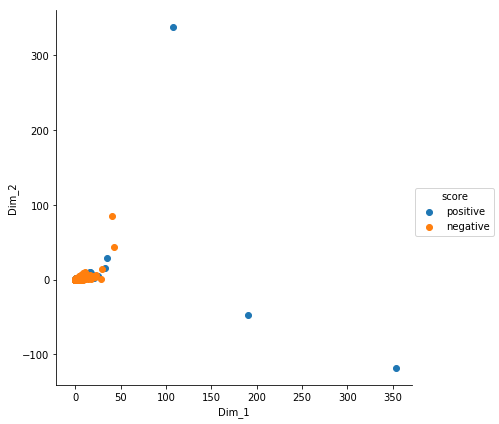

In [31]:
from sklearn.decomposition import TruncatedSVD as TSNE
import seaborn as sns
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(sample_2000)

tsne_data = np.vstack((tsne.T, score_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "score"))

sns.FacetGrid(tsne_df, hue='score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_reviews['CleanedText'])
final_tf_idf = final_tf_idf.todense()

print(final_tf_idf.shape)

(2000, 67275)


# t-SNE

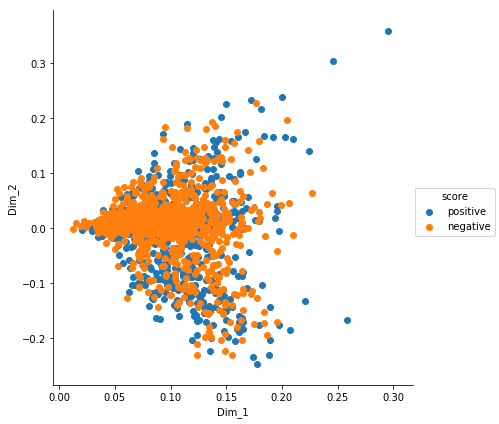

In [34]:
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(final_tf_idf)

tsne_data = np.vstack((tsne.T, score_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "score"))

sns.FacetGrid(tsne_df, hue='score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Word2Vec

In [1]:
import gensim
i = 0
list_of_sent =[]
for sent in final_reviews['CleanedText'].values:
    filtered_sentence =[]
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
        else:
            continue
    list_of_sent.append(filtered_sentence)

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


NameError: name 'final_reviews' is not defined

In [52]:
print(final['Text'].values[0])
print("*************")
print(list_of_sent[0])

does the trick, freshens the breath. But I find it loses its flavor within 5-10 minutes. I prefer ICECUBES over this gum.
*************
['hcg', 'diet', 'one', 'hell', 'great', 'way', 'lose', 'weight', 'grissini', 'breadstick', 'recommend', 'origin', 'protocol', 'hilari', 'crunchi', 'littl', 'basic', 'tasteless', 'stick', 'flour', 'water', 'becom', 'delici', 'eat', 'calori', 'week', 'compos', 'carb', 'except', 'realli', 'easi', 'stay', 'plan', 'honest', 'drop', 'fat', 'like', 'crazi', 'tini', 'italian', 'treasur', 'take', 'life', 'process', 'melba', 'toast', 'doesnt', 'stand', 'chanc']


In [53]:
w2v_model = gensim.models.Word2Vec(list_of_sent,min_count=5,size = 50,workers = 4 )

In [54]:
words = list(w2v_model.wv.vocab)
print(len(words))

2045


In [55]:
sent_vectors = []
for sent in (list_of_sent):
    sent_vec = np.zeros(50)
    cnt_words =0
    for word in sent:
        if word in words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
print(len(sent_vectors))
print(len(sent_vectors[0]))

2000
50


# t-SNE 

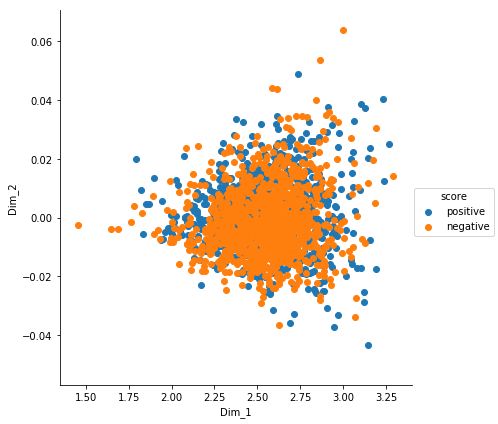

In [57]:
model = TSNE(n_components=2, random_state=0)
tsne = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne.T, score_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "score"))

sns.FacetGrid(tsne_df, hue='score', size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# TF-IDF Word2Vec

In [58]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_reviews['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [61]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names

tfidf_sent_vectors = []
row=0;
for sent in (list_of_sent):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

# t-SNE

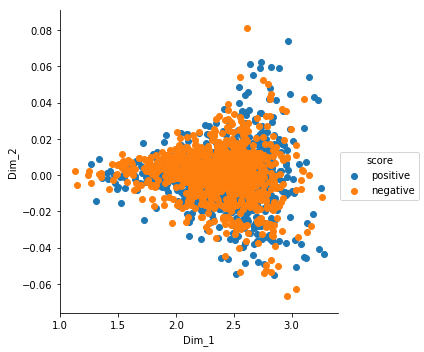

In [62]:
model = TSNE(n_components=2, random_state=15)
tfidf_w2v_points = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tfidf_w2v_points.T, score_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'score'))

sns.FacetGrid(tsne_df, hue='score', size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# Observation

From the above, we can say that, none of the technique is separate positive reviwes and negative reviews clearly. So, We can't obtain a Hyperplane.